<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/transferLearningFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from IPython.display import Image, display
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import cv2 #image operations

In [3]:
import pickle
import os
import random
import pandas as pd
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from PIL import Image

from tensorflow.keras import layers, models, backend, applications, regularizers, initializers
from tensorflow.keras.layers import Layer

from tensorflow.python.ops import math_ops

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils import class_weight
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.8.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
%cd /content/drive/MyDrive/Tesi

/content/drive/MyDrive/Tesi


In [ ]:
 !unzip DATA_svp.zip

Archive:  DATA_svp.zip
   creating: DATA_svp/test/
   creating: DATA_svp/test/D_OD&OS_SVP/
  inflating: DATA_svp/test/D_OD&OS_SVP/1728_maselli_angela__727_Angio Retina_OD_2017-06-15_10-24-50_F_1935-06-25_Enface-304x304-Superficial.png  
  inflating: DATA_svp/test/D_OD&OS_SVP/1728_maselli_angela__727_Angio Retina_OS_2017-06-15_10-29-38_F_1935-06-25_Enface-304x304-Superficial.png  
  inflating: DATA_svp/test/D_OD&OS_SVP/1763_dell'aera_annunaziata__683_Angio Retina_OD_2017-05-18_09-35-32_F_1948-08-15_Enface-304x304-Superficial.png  
  inflating: DATA_svp/test/D_OD&OS_SVP/1763_dell'aera_annunaziata__683_Angio Retina_OS_2017-05-18_09-39-37_F_1948-08-15_Enface-304x304-Superficial.png  
  inflating: DATA_svp/test/D_OD&OS_SVP/2049_giannone_raffaele__830_Angio Retina_OD_2017-10-12_10-49-42_M_1944-10-15_Enface-304x304-Superficial.png  
  inflating: DATA_svp/test/D_OD&OS_SVP/2049_giannone_raffaele__830_Angio Retina_OS_2017-10-12_10-52-24_M_1944-10-15_Enface-304x304-Superficial.png  
  inflating: 

In [7]:
dataset_dir = 'DATA_svp' #path to the folder
training_dir = 'DATA_svp/training' #we are putting together these string
validation_dir ='DATA_svp/validation'
test_dir = 'DATA_svp/test'


In [8]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/content/drive/MyDrive/Tesi/DATA_svp/test/*.png'): 
    im=Image.open(filename)

In [ ]:
from matplotlib import image

img_grad = image.imread("DATA_svp/test/HC_OD&OS_SVP/1432_de michele_giovanni__466_Angio Retina_OD_2016-11-10_11-11-47_M_1950-08-22_Enface-304x304-Superficial.png")
print( type(img_grad) )
print( img_grad.shape )

<class 'numpy.ndarray'>
(304, 304, 4)


In [9]:
    
training = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir, image_size=(304, 304), batch_size=32)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir, image_size=(304, 304), batch_size=32)
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(304, 304),shuffle= False, labels="inferred",
    label_mode="int",)


print(type(training))

Found 454 files belonging to 3 classes.
Found 119 files belonging to 3 classes.
Found 144 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:

for data, labels in training.take(1):
    print(data.shape)
    print(labels.shape)

(32, 304, 304, 3)
(32,)


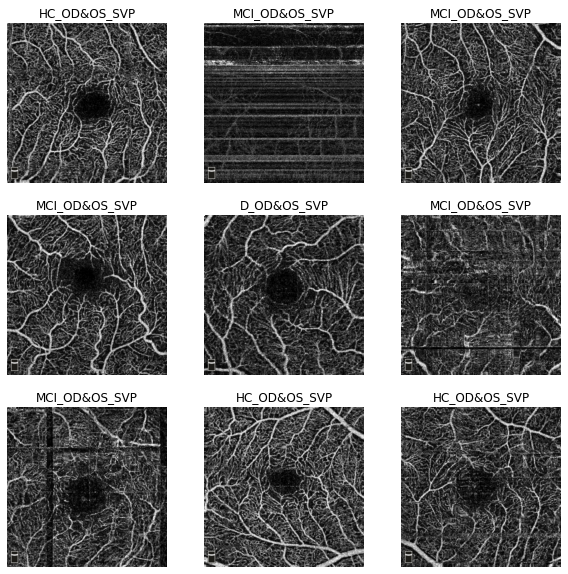

In [ ]:
import matplotlib.pyplot as plt
 
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

DENOISE FUNCTION DOES NOT WORK

In [ ]:
def denoise(img):
    '''remove noise from an image'''
    for images in training, validation, test:
      for img in images:
        img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    return img


##image data generator

In [10]:
from collections import Counter  
from keras.applications.vgg19 import VGG19, preprocess_input
im_gen= ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = im_gen.flow_from_directory(training_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb', 
                                      class_mode= 'categorical',   
                                      
                                    
                                      shuffle=True,
                                      seed=seed,)
counter = Counter(train_data.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

val_data = im_gen.flow_from_directory(validation_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical',   
                                      
                                      shuffle=True,
                                      seed=seed,)
test_data = im_gen.flow_from_directory(test_dir, 
                                      target_size=(304,304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical',                                  
                                      
                                      
                                      shuffle=False,
                                      seed=seed,)

aug_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
    
    rotation_range=3,)

aug_train_data = aug_img_gen.flow_from_directory(training_dir,
                                                 target_size=(304, 304),
                                                  color_mode='rgb',    
                                                  class_mode= 'categorical',   
                                                  batch_size=32,
                                                  shuffle=True,
                                                  seed=seed,)
images, labels = next(aug_train_data)

print(images.shape)
print(labels.shape)
print(class_weights)

Found 454 images belonging to 3 classes.
Found 119 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 454 images belonging to 3 classes.
(32, 304, 304, 3)
(32, 3)
{0: 3.7611940298507465, 1: 1.8666666666666667, 2: 1.0}


In [ ]:
#true test labels
y_true = test_data.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [ layers.RandomRotation(0.02),]
)

In [18]:
input_shape= (304,304,3)
batch_size = 32

##multi class GEV ACTIVATION FUNCTION

In [19]:
class GEV(Layer):
    def __init__(self, **kwargs):
        super(GEV, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        self.sigma = self.add_weight(name='sigma',
                                     shape=(1,),
                                     initializer=tf.constant_initializer(1.),
                                     trainable=True,
                                     dtype='float32')
        self.xi = self.add_weight(name='xi',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        super(GEV, self).build(input_shape)
 
    def call(self, x):

        sigma = backend.maximum(backend.epsilon(), self.sigma)  # sigma<0 doesn't make sense

        # Type 1: For xi = 0 (Gumbel)
        def t1(x=x, mu=self.mu, sigma=sigma):
            return backend.exp(-backend.exp(-(x-self.mu)/sigma))

        # Type 2: For xi>0 (Frechet) or xi<0 (Reversed Weibull) 
        def t23(x=x, mu=self.mu, sigma=sigma, xi=self.xi):
            y = (x - mu) / sigma
            y = xi*y
            y = tf.maximum(tf.constant(-1.), y)
            y = backend.exp(-tf.pow( tf.constant(1.) + y, -tf.constant(1.)/xi))        
            return y 

        GEV = tf.cond(backend.equal(tf.constant(0.), self.xi), t1, t23) # This chooses the type based on xi
        return GEV 

    def compute_output_shape(self, input_shape):
        return input_shape


class mGEV(Layer):

    def __init__(self, **kwargs):
        super(mGEV, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(input_shape[-1],),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        self.sigma = self.add_weight(name='sigma',
                                     shape=(input_shape[-1],),
                                     initializer=tf.constant_initializer(1.),
                                     trainable=True,
                                     dtype='float32')
        self.xi = self.add_weight(name='xi',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.1),
                                  regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5),
                                  trainable=True,
                                  dtype='float32')
        super(mGEV, self).build(input_shape)
 
    def call(self, x):
        mu = backend.cast(self.mu, 'float32')
        sigma = backend.cast(self.sigma, 'float32')
        xi = backend.cast(self.xi, 'float32')
        x = backend.cast(x, 'float32')
        x = tf.clip_by_value(x, -20, 20) 

        sigma = backend.maximum(backend.epsilon(), sigma)
        

        # Type 1: For xi = 0 (Gumbel)
        def t1(x=x, mu=mu, sigma=sigma, xi=xi):
            return backend.exp(-backend.exp(-(x-mu)/sigma)) 

        # Type 2: For xi>0 (Frechet) or xi<0 (Reversed Weibull) 
        def t23(x=x, mu=mu, sigma=sigma, xi=xi):        
            y = (x - mu) / sigma
            y = xi*y
            tf.debugging.assert_all_finite(y, 'xi*y',name=None)
            y = tf.maximum(tf.constant(-1., dtype='float32'), y)
            y = backend.exp(-tf.pow( tf.constant(1., dtype='float32') + y, -tf.constant(1., dtype='float32')/xi))       
            return y 

        mGEV = tf.cond(backend.equal(tf.constant(0., dtype='float32'), backend.cast(xi, 'float32')), t1, t23) 
        mGEV = mGEV/tf.math.reduce_sum(mGEV)
        return mGEV 

    def compute_output_shape(self, input_shape):
        return input_shape

In [20]:
#this is a basic model to see the initial scores, without TL and FT
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    #input_layer= data_augmentation(inputs)

    #resize_layer = tfkl.Resizing(224, 224, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        
        
        name = 'Conv1')(input_layer)
    act1= keras.layers.LeakyReLU(alpha=0.2)(conv1)
    pool1 = tfkl.MaxPooling2D(name = 'Pool1')(act1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
       
        
        name = 'Conv2')(act1)
    act2= keras.layers.LeakyReLU(alpha=0.2)(conv2)
    pool2 = tfkl.MaxPooling2D(name = 'Pool1')(act2)

    
  
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(pool2)
    
    
    classifier_layer = tfkl.Dropout(0.4, seed=seed, name='ClassifierDropout')(glob_pooling)

    output_layer = tfkl.Dense(
        units=3, 
         kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation= 'softmax',
        name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()],)

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 304, 304, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 304, 304, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 304, 304, 8)       0         
                                                                 
 Conv2 (Conv2D)              (None, 304, 304, 16)      1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 304, 304, 16)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 152, 152, 16)      0         
                                                                 
 GlobalPooling (GlobalAverag  (None, 16)               0     

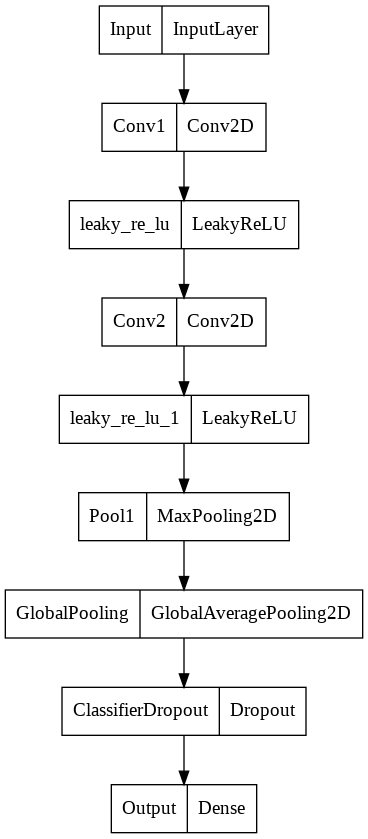

In [21]:
standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)



In [22]:
# Train the model
standard_history = standard_model.fit(
    aug_train_data, 
    batch_size = batch_size,
    epochs = 20,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/20
15/15 [==============================] - 85s 5s/step - loss: 20.1750 - categorical_accuracy: 0.3921 - val_loss: 9.3528 - val_categorical_accuracy: 0.5294
Epoch 2/20
15/15 [==============================] - 11s 738ms/step - loss: 7.5005 - categorical_accuracy: 0.4317 - val_loss: 2.9665 - val_categorical_accuracy: 0.3950
Epoch 3/20
15/15 [==============================] - 11s 741ms/step - loss: 3.5805 - categorical_accuracy: 0.4031 - val_loss: 2.1850 - val_categorical_accuracy: 0.4790
Epoch 4/20
15/15 [==============================] - 11s 746ms/step - loss: 2.2016 - categorical_accuracy: 0.4515 - val_loss: 1.3536 - val_categorical_accuracy: 0.4286
Epoch 5/20
15/15 [==============================] - 11s 737ms/step - loss: 1.5228 - categorical_accuracy: 0.4163 - val_loss: 1.3177 - val_categorical_accuracy: 0.4202
Epoch 6/20
15/15 [==============================] - 11s 738ms/step - loss: 1.6715 - categorical_accuracy: 0.4581 - val_loss: 1.1613 - val_categorical_accuracy: 0.4454


##TRANFER LEARNING

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

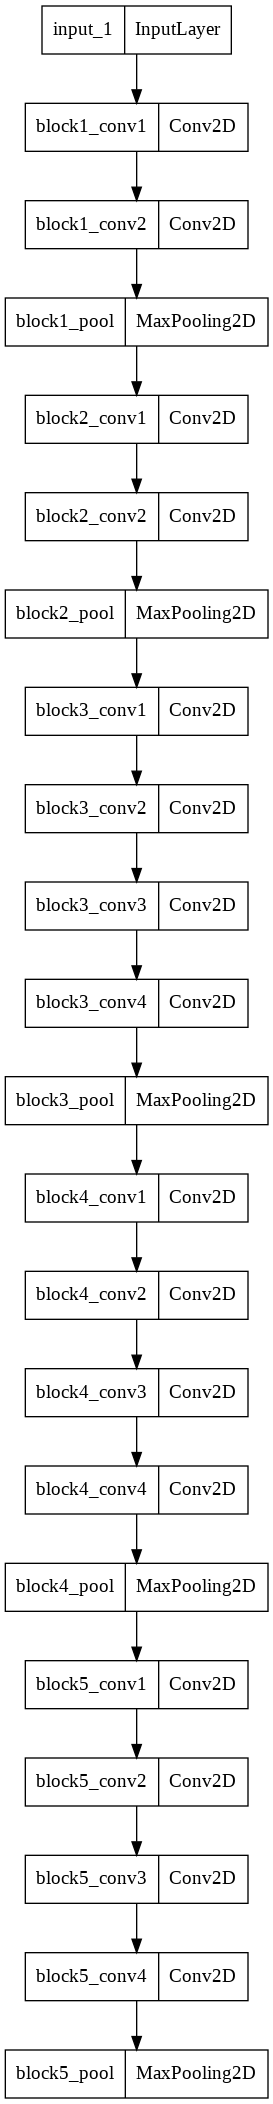

In [23]:
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [24]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(304,304,3))
x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
x = supernet(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
outputs = keras.layers.Dense(3, activation= 'softmax')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                             

In [25]:
# Train the model
tl_history = tl_model.fit(
    aug_train_data,
    batch_size = batch_size,
    epochs = 40,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/40
15/15 [==============================] - 18s 952ms/step - loss: 2.5262 - accuracy: 0.4251 - val_loss: 1.5177 - val_accuracy: 0.4118
Epoch 2/40
15/15 [==============================] - 12s 789ms/step - loss: 2.2246 - accuracy: 0.4626 - val_loss: 1.4461 - val_accuracy: 0.4286
Epoch 3/40
15/15 [==============================] - 12s 784ms/step - loss: 2.0587 - accuracy: 0.4383 - val_loss: 1.4237 - val_accuracy: 0.3697
Epoch 4/40
15/15 [==============================] - 12s 784ms/step - loss: 1.7571 - accuracy: 0.4626 - val_loss: 1.4398 - val_accuracy: 0.3782
Epoch 5/40
15/15 [==============================] - 12s 788ms/step - loss: 1.5818 - accuracy: 0.4868 - val_loss: 1.5290 - val_accuracy: 0.5042
Epoch 6/40
15/15 [==============================] - 12s 785ms/step - loss: 1.4537 - accuracy: 0.4890 - val_loss: 1.2465 - val_accuracy: 0.3866
Epoch 7/40
15/15 [==============================] - 12s 785ms/step - loss: 1.4406 - accuracy: 0.4361 - val_loss: 1.3888 - val_accuracy: 0.4034

In [27]:
# Save the best model
tl_model.save('TransferLearningModel1')

INFO:tensorflow:Assets written to: TransferLearningModel1/assets


##FINE TUNING

In [28]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel1')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                             

In [29]:
# Set all VGG layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [30]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 

In [31]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [34]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_data,
    
    epochs = 40,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor= 'val_loss', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/40
15/15 [==============================] - 6s 372ms/step - loss: 0.5858 - accuracy: 0.7379 - val_loss: 1.9694 - val_accuracy: 0.3193
Epoch 2/40
15/15 [==============================] - 5s 346ms/step - loss: 0.4496 - accuracy: 0.8524 - val_loss: 3.3082 - val_accuracy: 0.4538
Epoch 3/40
15/15 [==============================] - 5s 340ms/step - loss: 0.3985 - accuracy: 0.8899 - val_loss: 2.9322 - val_accuracy: 0.3782
Epoch 4/40
15/15 [==============================] - 5s 339ms/step - loss: 0.1524 - accuracy: 0.9515 - val_loss: 3.5064 - val_accuracy: 0.3613
Epoch 5/40
15/15 [==============================] - 5s 341ms/step - loss: 0.1969 - accuracy: 0.9229 - val_loss: 2.5033 - val_accuracy: 0.3025
Epoch 6/40
15/15 [==============================] - 5s 347ms/step - loss: 0.1038 - accuracy: 0.9648 - val_loss: 4.0989 - val_accuracy: 0.3782
Epoch 7/40
15/15 [==============================] - 5s 346ms/step - loss: 0.0493 - accuracy: 0.9824 - val_loss: 5.1246 - val_accuracy: 0.4538
Epoch 

#con il fine tuning il modello overfitta.

In [ ]:
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
pred=ft_model.predict(test_data, steps=len(test_data), verbose=1)

AttributeError: ignored

In [ ]:
 #predicted test labels
 y_pred = np.rint(pred)

In [ ]:
pred[0]

array([ 228.66878,  300.56894, -650.5174 ], dtype=float32)

In [ ]:
y_pred

array([[ 229.,  301., -651.],
       [ 223.,  288., -636.],
       [ 236.,  304., -661.],
       [ 234.,  299., -662.],
       [ 241.,  306., -669.],
       [ 227.,  298., -647.],
       [ 235.,  304., -669.],
       [ 246.,  319., -685.],
       [ 245.,  320., -690.],
       [ 248.,  314., -694.],
       [ 247.,  319., -692.],
       [ 253.,  332., -706.],
       [ 221.,  270., -617.],
       [ 234.,  299., -652.],
       [ 240.,  307., -682.],
       [ 238.,  305., -668.],
       [ 240.,  310., -677.],
       [ 253.,  331., -729.],
       [ 251.,  318., -713.],
       [ 233.,  303., -666.],
       [ 238.,  309., -671.],
       [ 247.,  318., -689.],
       [ 237.,  310., -671.],
       [ 259.,  330., -720.],
       [ 259.,  334., -717.],
       [ 231.,  293., -650.],
       [ 237.,  306., -670.],
       [ 227.,  295., -641.],
       [ 241.,  310., -678.],
       [ 240.,  306., -685.],
       [ 238.,  302., -664.],
       [ 235.,  309., -668.],
       [ 253.,  317., -701.],
       [ 2

In [ ]:
predicted_class = np.argmax(pred, axis=-1)

In [ ]:
predicted_class[0]

1

In [ ]:
predicted_class

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

##METRICS

In [35]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.SensitivityAtSpecificity( 0.5),
     
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#ROC-AUC

0= DEMENTIA: 3.7611940298507465,


1:HEALTHY CONTROL 1.8666666666666667,


2:MILD COGNITIVE IMPAIRMENT *1.0*

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
pred = tl_model.predict(test_data)
pred = np.argmax(pred,axis=1) 

In [ ]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn import metrics

score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.5625


In [ ]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = tl_model.predict(test_data)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_true, pred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
pred = np.argmax(pred,axis=1) 

Numpy array of predictions


array([[ -9.1952,   5.1915,   8.1589],
       [ -6.7406,   5.1332,   7.2871],
       [ -7.662 ,   5.1716,   5.4001],
       [-10.1768,   4.9   ,   6.8564],
       [ -9.227 ,   5.4679,   9.3433]], dtype=float32)

As percent probability
[-919.5153  519.1454  815.8937]
Log loss score: 4.046270115507974


In [ ]:
prob_vector = tl_model.predict(test_data)[:, 1]

In [ ]:
prob_vector.shape

(144,)

In [ ]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

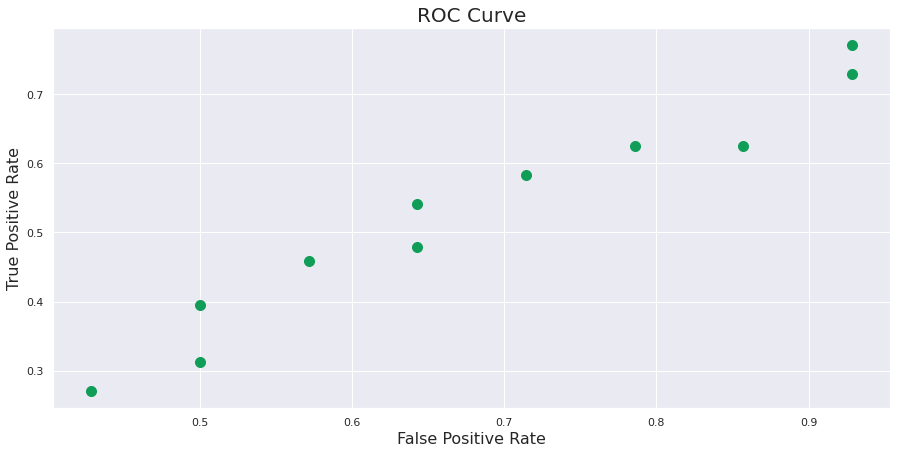

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
plt.figure(figsize=(15,7))

ROC = roc_from_scratch(prob_vector,y_true,partitions=10)
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [ ]:
def create_triangle(tpr_0,tpr_1,fpr_0,fpr_1):
    plt.plot([tpr_0,tpr_1],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_1],[fpr_1,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_0],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    print('area: ',(tpr_0-tpr_1)*(fpr_0-fpr_1)/2)

def create_rectangle(tpr_0,fpr_0):
    plt.plot([tpr_0,tpr_0],[fpr_0,0], 'k-', lw=2,color='#4285F4')

In [ ]:
import pandas as pd
import numpy as np
partitions = 100
ROC = roc_from_scratch(prob_vector, y_true, partitions=partitions)
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
rectangle_roc

0.2648809523809524

##GRADCAM

In [ ]:
np.argmin(pred)

308

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
my_image = load_img('DATA_svp/test/HC_OD&OS_SVP/1432_de michele_giovanni__466_Angio Retina_OD_2016-11-10_11-11-47_M_1950-08-22_Enface-304x304-Superficial.png', target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_image)
#my_image = my_image.reshape((1,304,304, 1))
my_image = preprocess_input(my_image)

#make the prediction
prediction = ft_model.predict(my_image)

ValueError: ignored

In [ ]:
import cv2

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[ft_model.inputs],
			outputs=[ft_model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

In [ ]:
layer_name = 'vgg19'
grad_cam=GradCam(ft_model,np.expand_dims(img_grad, axis=0),layer_name)

ValueError: ignored